# 3D Reconstruction Tutorial

One of the key computer vision problems today is to be able to create 3D models or spaces based on a 2D input. In this tutorial, we will look at how we can use FiftyOne and 3D Reconstruction models to generate 3D meshes. Let's start with just a single image with Single Shot Reconstruction!

## Single Shot Reconstruction

3D Reconstruction can be performed with a variety of different inputs, but what makes Single Shot Reconstruction special is that it only requires a single input image. The hierarchy of models will then generate all the necesary components to generate a 3D mesh with textures. We will be checking out [Instant Mesh](https://github.com/TencentARC/InstantMesh) to generate a 3D model of our favorite Pokemon! We can kick things off by downloading our [Pokemon dataset](https://www.kaggle.com/datasets/rounakbanik/pokemon) from kaggle.

### Installation

In [ ]:
!kaggle datasets download -d divyanshusingh369/complete-pokemon-library-32k-images-and-csv

In [ ]:
!unzip complete-pokemon-library-32k-images-and-csv.zip

In [ ]:
!git clone https://github.com/TencentARC/InstantMesh.git && cd InstantMesh

Instant Mesh Install Steps for bash 👇

In [ ]:
conda create --name instantmesh python=3.10
conda activate instantmesh
pip install -U pip

# Ensure Ninja is installed
conda install Ninja

# Install the correct version of CUDA
conda install cuda -c nvidia/label/cuda-12.1.0

# Install PyTorch and xformers
# You may need to install another xformers version if you use a different PyTorch version
pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121
pip install xformers==0.0.22.post7

# For Linux users: Install Triton 
pip install triton

# For Windows users: Use the prebuilt version of Triton provided here:
pip install https://huggingface.co/r4ziel/xformers_pre_built/resolve/main/triton-2.0.0-cp310-cp310-win_amd64.whl

# Install other requirements
pip install -r requirements.txt

### Loading Our Pokemon Dataset

We load our dataset in seemlessly using the [ImageClassificationDirectoryTree](https://docs.voxel51.com/user_guide/dataset_creation/datasets.html#imageclassificationdirectorytree-import) importer. After the dataset is in, we can visualize it by launching the app!

In [1]:
import fiftyone as fo
import os

name = "Pokemon Images"
dataset_dir = "Pokemon Images DB/Pokemon Images DB/"

# Create the dataset
dataset = fo.Dataset.from_dir(
    dataset_dir=dataset_dir,
    dataset_type=fo.types.ImageClassificationDirectoryTree,
    name=name,
    overwrite=True
)

dataset.persistent = True

# View summary info about the dataset
print(dataset)

 100% |███████████████| 2374/2374 [482.7ms elapsed, 0s remaining, 4.9K samples/s]      
Name:        Pokemon Images
Media type:  image
Num samples: 2374
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


We can launch the app to take a look at all of our Pokemon with both a white and black backround to play around with. The flexible background is great as for some image to 3D examples, one background type may work much better than others!

In [ ]:
session = fo.launch_app(dataset)

Generating meshes can be very computationally expensive, so in order to save time, let us choose one or two of our favorite Pokemon. Don't know which to pick? Explore the app and find one that you like!

In [3]:
from fiftyone import ViewField as F

view = dataset.filter_labels(
    "ground_truth", (F("label") == "Pikachu") | (F("label") == "Charmander")
)

Instant Mesh provides tons of information along the way of generating our mesh that we are able to visualize in the app. Since we are going to have samples with images, videos, and meshes, this is a perfect oppurtunity for us to create a new [FiftyOne Grouped Dataset](https://docs.voxel51.com/user_guide/groups.html), a dataset that can hold groups of samples of any modality you like! We start by creating the daaset and adding a group slice to it.

In [19]:
name = "Pokemon Meshes"
# Create the dataset
mesh_dataset = fo.Dataset(name,overwrite=True)

mesh_dataset.add_group_field("group", default="Pokemon Picture")


### Generating Our New Single Shot Meshes

The tutorial provides two different ways to generate the mesh. If you are able to run the GPU intensive model Instant Mesh, the following below is an example on how. If not, there is also an option to run Instant Mesh on [Replicate](https://replicate.com/camenduru/instantmesh/api), an easy to use model serving provider. 

### Local InstantMesh Inference

In [31]:
def generate_meshes(sample, output_dir):

    """
    A function that runs InstantMesh locally using python subprocess. InstantMesh will then save all generated files to the output_dir.

    Args:
        sample: A FiftyOne sample to pass into InstantMesh, must have media_type = "image"
        output_dir: The destination of generated files by InstantMesh
    """
    
    # Grab the filepath to pass in
    name =  sample.filepath.split("/")[-1].split(".")[0]
    filepath = os.path.abspath(sample.filepath)
    filepath = '"' + filepath + '"'
    
    command = "cd ./InstantMesh && python run.py configs/instant-mesh-base.yaml " + \
    filepath + " --export_texmap --output_path " + output_dir
    
    # Run InstantMesh through subprocess
    result = subprocess.run(command, shell=True,capture_output=True, text=True)
    # uncomment to see model progress!
    # print(result)
    

In [18]:
def create_grouped_mesh_samples(sample, output_dir):

    """
    A function that loads the InstantMesh outputs into a FiftyOne Group. Returns a list of all the samples in the group.

    Args:
        sample: The original sample used to generate the Instant Mesh outputs
        output_dir: The destination of generated files by InstantMesh
    """
    samples = []
    
    # Define Our Group
    group = fo.Group()

    name =  sample.filepath.split("/")[-1].split(".")[0]
    
    # First we add the input Pokemon picture
    input_sample = fo.Sample(filepath=sample.filepath, group=group.element("Pokemon Picture"))
    samples.append(input_sample)
    
    # Next we add the intermediary stereo image
    mv_show_path = output_dir + "/instant-mesh-base/images/" + name + ".png"
    stereo_sample = fo.Sample(filepath=mv_show_path, group=group.element("MV Show Image"))
    samples.append(stereo_sample)
    
    
    # Next we add a video of our 3D mesh if exists
    video_path = output_dir + "/instant-mesh-base/videos/" + name + ".mp4"
    if os.path.exists(video_path):
        video_sample = fo.Sample(filepath=video_path, group=group.element("Video"))
        samples.append(video_sample)
    
    # Next we define the paths to our mesh files
    obj_path = output_dir + "/instant-mesh-base/meshes/"  + name + ".obj"
    
    mtl_path = output_dir + "/instant-mesh-base/meshes/" + name + ".mtl"

    # We load in with ObjMesh and pass our files in
    obj = fo.ObjMesh(name=sample["ground_truth"].label, obj_path=obj_path, mtl_path=mtl_path)
    
    # We define our scene and save it so it can be loaded into FiftyOne
    scene = fo.Scene(camera=fo.PerspectiveCamera(up="Z"))
    scene.add(obj)
    scene_path = output_dir + "/instant-mesh-base/meshes/" + sample.id + ".fo3d"
    scene.write(scene_path)
        
    # Finally we add the scene as a sample
    mesh_sample = fo.Sample(scene_path, group=group.element("Mesh"))
    samples.append(mesh_sample)
    
    # Return all our new samples back
    return samples

With our helper functions defined, we can now run Instant Mesh and view our newly generated meshes!

In [ ]:
import subprocess

output_dir = "/path/to/output_dir"


for poke_sample in view:
    
    generate_meshes(poke_sample, output_dir)
    samples = create_grouped_mesh_samples(poke_sample, output_dir)
    
    mesh_dataset.add_samples(samples)

In [ ]:
session.dataset = mesh_dataset

Let's see how our Pikachu turned out!

![pikachu](assets/pikachu.gif)

### Run with Replicate Model Serving

Below we can use [replicate](https://replicate.com) to serve us [InstantMesh](https://replicate.com/camenduru/instantmesh) as well! Define your $REPLICATE_API_TOKEN before running in the terminal!

In [ ]:
!pip install replicate

In [22]:
import requests

def download_image(image_url, filename):
    img_data = requests.get(image_url).content
    with open(filename, "wb") as handler:
        handler.write(img_data)

Let us create some destinations for the new files we will be creating!

In [23]:
output_dir = "/home/dan/Documents/docs/3d_reconstruction/instantmesh_outputs"

os.makedirs(output_dir + "/mv_show_images", exist_ok=True)
os.makedirs(output_dir + "/videos", exist_ok=True)
os.makedirs(output_dir + "/meshes", exist_ok=True)
os.makedirs(output_dir + "/images", exist_ok=True)

In [ ]:
import replicate 
samples = []

for poke_sample in view:

    # Set Inputs
    image_path = open(poke_sample.filepath, "rb")
    inputs = {
        "image_path": image_path,
        "export_texmap": True
    }

    # Run the Replicate Model
    output = replicate.run(
        "camenduru/instantmesh:4f151757fd04d508b84f2192a17f58d11673971f05d9cb1fd8bd8149c6fc7cbb",
        input=inputs
    )
    
    group = fo.Group()

    # First create our input sample
    sample = fo.Sample(filepath=poke_sample.filepath, group=group.element("Pokemon Picture"))
    samples.append(sample)

    # Download and add the MV image sample
    download_path = output_dir + "/mv_show_images/" + poke_sample.id + ".png"
    download_image(output[0], download_path)
    sample = fo.Sample(filepath=download_path, group=group.element("MV Show Image"))
    samples.append(sample)

    # Download and add the 3D video
    download_path = output_dir + "/videos/" + output[1].split("/")[-1]
    download_image(output[1], download_path)
    sample = fo.Sample(filepath=download_path, group=group.element("Video"))
    samples.append(sample)

    # Download and add the mesh files
    download_path_obj = output_dir + "/meshes/" + output[2].split("/")[-1]
    download_image(output[2], download_path_obj)
    
    download_path_mtl = output_dir + "/meshes/" + output[3].split("/")[-1]
    download_image(output[3], download_path_mtl)
    
    download_path_image = output_dir + "/meshes/" + output[4].split("/")[-1]
    download_image(output[4], download_path_image)
    
    obj = fo.ObjMesh(name=poke_sample["ground_truth"].label, obj_path=download_path_obj, mtl_path=download_path_mtl)

    # Create the Scene Sample
    scene = fo.Scene(camera=fo.PerspectiveCamera(up="Z"))
    scene.add(obj)   
    scene_path = output_dir + "/meshes/" + poke_sample.id + ".fo3d"
    scene.write(scene_path)
    
    sample = fo.Sample(scene_path, group=group.element("Mesh"))
    samples.append(sample)

mesh_dataset.add_samples(samples)


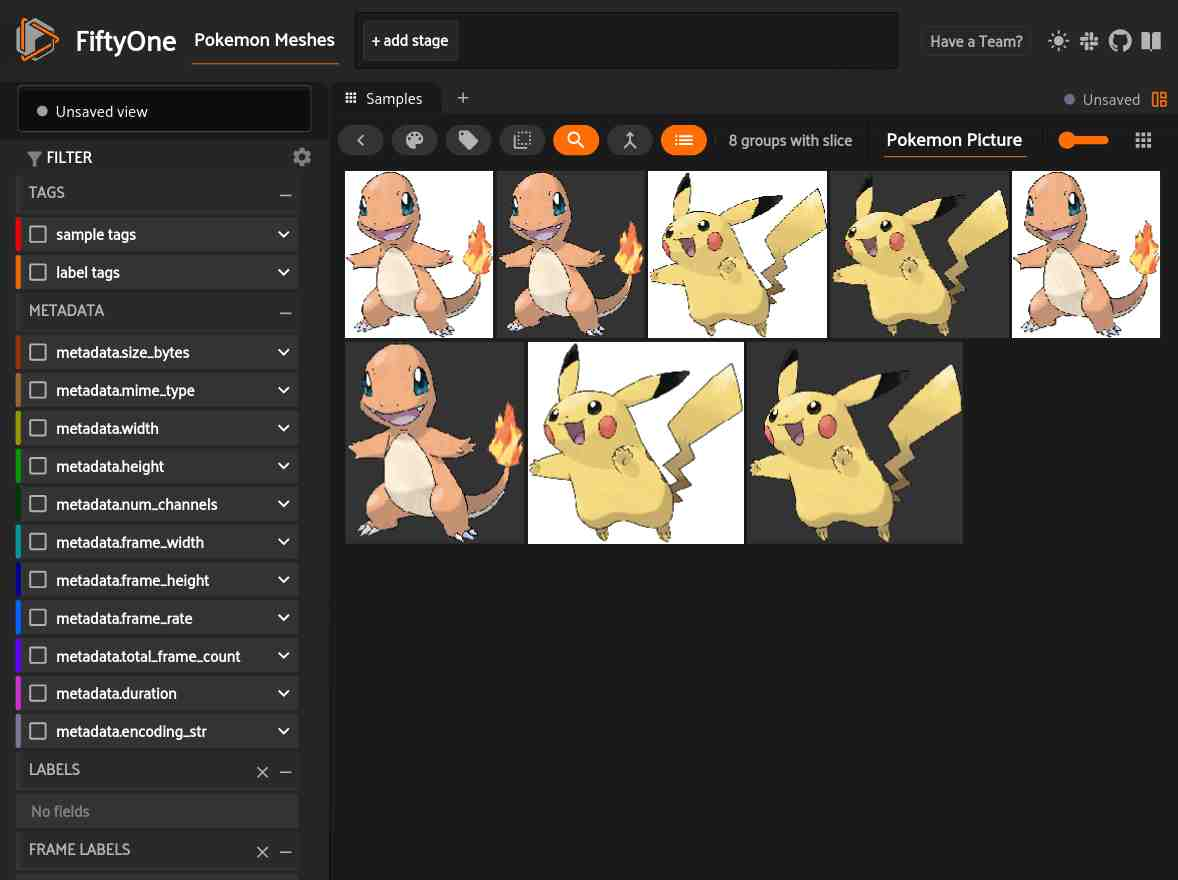

In [28]:
session.dataset = mesh_dataset

Let's check our Charmander!

![charmander](assets/charmander.gif)

## MVS Reconstruction

The other most popular form of 3D Reconstruction is Multi-View Stereo Models. These models unlike the previous one take in multiple different angles to produce a sharp and accurate 3D Model. The data going in can vary from just a few images with camera intrinsics or full videos. After some preprocessing, the model takes the input and is able to generate the full 3D mesh. MVS models tend to perform better on tasks that require creating a 3D mesh for an entire room or building exterior. Let's take a look on how to generate a mesh using [simplerecon](https://github.com/nianticlabs/simplerecon) on scene data they have provided

In [1]:
!git clone https://github.com/nianticlabs/simplerecon.git

Cloning into 'simplerecon'...
remote: Enumerating objects: 468, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 468 (delta 171), reused 160 (delta 157), pack-reused 265
Receiving objects: 100% (468/468), 13.01 MiB | 30.83 MiB/s, done.
Resolving deltas: 100% (282/282), done.


We need to download the demo dataset as well as the model checkpoint in order to inference. We will use the [eta](https://github.com/voxel51/eta) library to handle both of these tasks.

In [2]:
!pip install kornia==0.6.7 antialiased-cnns efficientnet_pytorch timm trimesh transforms3d einops moviepy \
pyrender    scipy  setuptools==59.5.0 open3d pytorch-lightning==1.5.4

  Using cached efficientnet_pytorch-0.7.1.tar.gz (21 kB)
  Preparing metadata (setup.py) ... done
  Using cached transforms3d-0.4.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached setuptools-59.5.0-py3-none-any.whl.metadata (5.0 kB)
INFO: pip is looking at multiple versions of jupyter-packaging to determine which version is compatible with other requirements. This could take a while.


  Using cached packaging-24.0-py3-none-any.whl.metadata (3.2 kB)


  Using cached aiofiles-22.1.0-py3-none-any.whl.metadata (8.0 kB)
Using cached setuptools-59.5.0-py3-none-any.whl (952 kB)
Using cached transforms3d-0.4.1-py3-none-any.whl (1.4 MB)
Using cached packaging-24.0-py3-none-any.whl (53 kB)
Using cached aiofiles-22.1.0-py3-none-any.whl (14 kB)
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=201d530f2c88e07b2e856248bc01516eabcac8ec4f575fd38a9be9c9dacdcab5
  Stored in directory: /home/dan/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet_pytorch
DEPRECATION: pytorch-lightning 1.5.4 has a non-standard dependency specifier torch>=1.7.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
import eta.core.web as etaw
import eta.core.utils as etau

data_path = "vdr.zip"
etaw.download_google_drive_file("1x-auV7vGCMdu5yZUMPcoP83p77QOuasT", path=data_path)
etau.extract_zip(data_path, delete_zip=True)

ckpt_path = "./simplerecon/weights/hero_model.ckpt"
etaw.download_google_drive_file("1hCuKZjEq-AghrYAmFxJs_4eeixIlP488", path=ckpt_path)


Start by loading in our demo dataset, vdr. Since the dataset format is custom, we will load it in ourselves manually. Luckily, we can handle custom data ingestion easily with just the following code.

In [4]:
import fiftyone as fo
import os 

vdr_dataset = fo.Dataset("vdr", overwrite=True)

scans = os.listdir("./vdr/scans")

samples = []
for scan in scans:
    scan_list = os.listdir("./vdr/scans/" + scans[0])
    scan_list.sort()
    frame_files = [file for file in scan_list if file.startswith("frame")]
    
    for frame in frame_files:
        sample = fo.Sample("./vdr/scans/" + scan + "/" + frame)
        sample["frame"] = int(frame.split("_")[1].split(".")[0])
        sample["scan"] = scan
        samples.append(sample)
        
vdr_dataset.add_samples(samples)


 100% |███████████████| 2336/2336 [267.0ms elapsed, 0s remaining, 8.8K samples/s]   


['663efc512ce92c4590be0d56',
 '663efc512ce92c4590be0d57',
 '663efc512ce92c4590be0d58',
 '663efc512ce92c4590be0d59',
 '663efc512ce92c4590be0d5a',
 '663efc512ce92c4590be0d5b',
 '663efc512ce92c4590be0d5c',
 '663efc512ce92c4590be0d5d',
 '663efc512ce92c4590be0d5e',
 '663efc512ce92c4590be0d5f',
 '663efc512ce92c4590be0d60',
 '663efc512ce92c4590be0d61',
 '663efc512ce92c4590be0d62',
 '663efc512ce92c4590be0d63',
 '663efc512ce92c4590be0d64',
 '663efc512ce92c4590be0d65',
 '663efc512ce92c4590be0d66',
 '663efc512ce92c4590be0d67',
 '663efc512ce92c4590be0d68',
 '663efc512ce92c4590be0d69',
 '663efc512ce92c4590be0d6a',
 '663efc512ce92c4590be0d6b',
 '663efc512ce92c4590be0d6c',
 '663efc512ce92c4590be0d6d',
 '663efc512ce92c4590be0d6e',
 '663efc512ce92c4590be0d6f',
 '663efc512ce92c4590be0d70',
 '663efc512ce92c4590be0d71',
 '663efc512ce92c4590be0d72',
 '663efc512ce92c4590be0d73',
 '663efc512ce92c4590be0d74',
 '663efc512ce92c4590be0d75',
 '663efc512ce92c4590be0d76',
 '663efc512ce92c4590be0d77',
 '663efc512ce9

We can visualize our samples within the app. Check out [dynamic groups](https://docs.voxel51.com/user_guide/using_views.html#view-groups) by grouping our dataset by scan and ordering by frame:

In [5]:
vdr_dataset.persistent = True


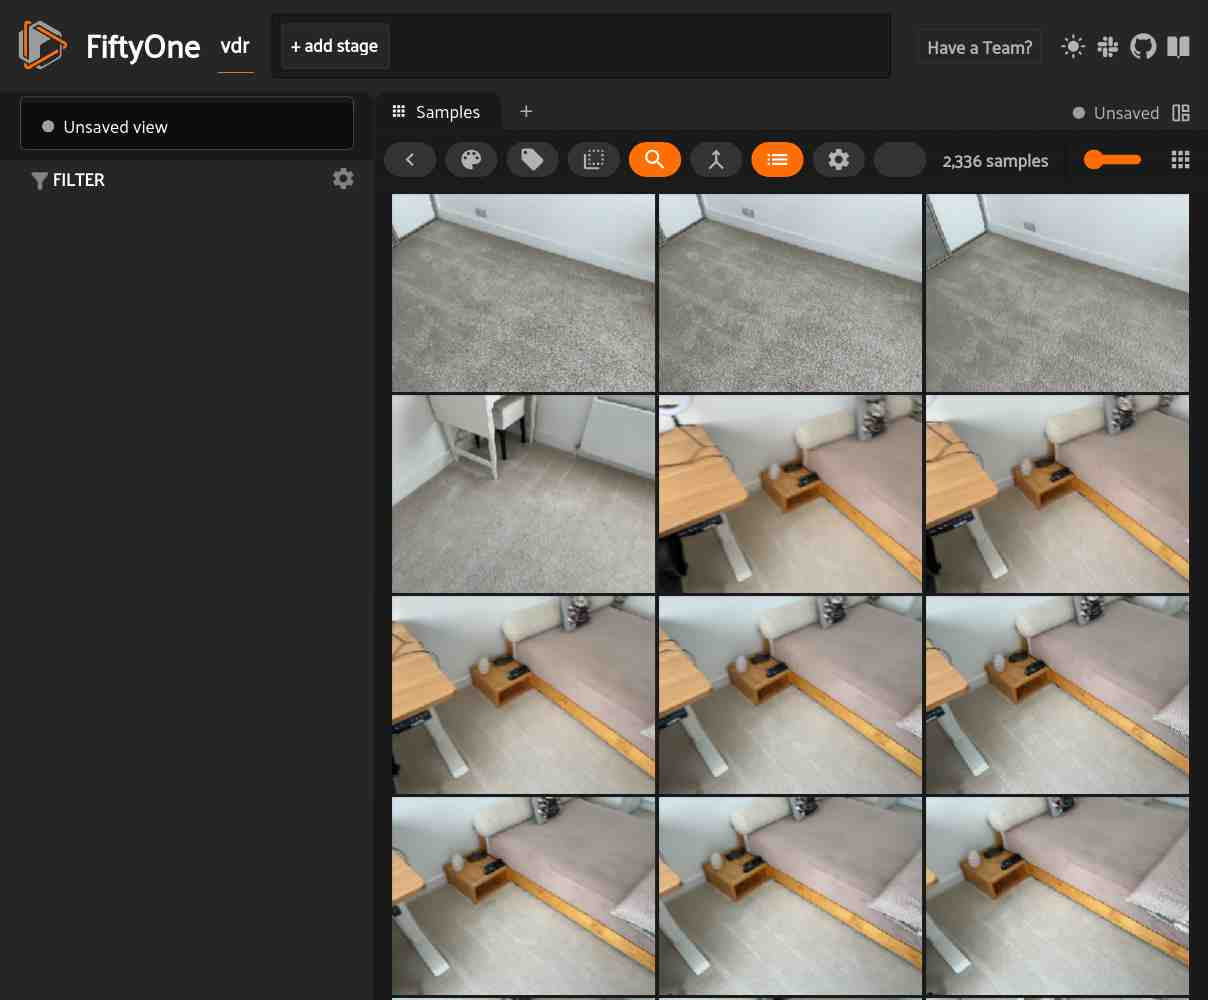

In [6]:
session = fo.launch_app(vdr_dataset)

![vdr](assets/vdr.gif)

To begin inference, we will use simplerecons test.py to generate the meshes for the demo dataset. We use python subprocess again to call the model for us with the apropriate input variables. The command will generate meshes for both scans in our demo dataset and output them to our specified directory.

In [7]:
import subprocess

output_dir = "/home/dan/Documents/docs/3d_reconstruction/simplerecon_outputs"

command = "cd ./simplerecon && python test.py --name HERO_MODEL \
            --output_base_path " + output_dir + " \
            --config_file configs/models/hero_model.yaml \
            --load_weights_from_checkpoint weights/hero_model.ckpt \
            --dataset_path ../vdr \
            --tuple_info_file_location data_splits/vdr/  \
            --dataset_scan_split_file data_splits/vdr/scans.txt     \
            --dataset vdr           \
            --mv_tuple_file_suffix _eight_view_deepvmvs_dense.txt    \
            --num_images_in_tuple 8           \
            --frame_tuple_type dense            \
            --split test             \
            --num_workers 8 \
            --batch_size 2 \
            --fast_cost_volume \
            --run_fusion \
            --depth_fuser open3d \
            --fuse_color \
            --dump_depth_visualization \
            --cache_depths "
    
result = subprocess.run(command, shell=True,capture_output=True, text=True)

In [ ]:
result

Our model will output two key predictions, the mesh as we mentioned but also the predicted depth maps, which are used to generate the 3D meshes. We can visualize all of our depth maps easily by adding them to our VDR dataset using fo.Heatmaps()! [LINK]. Afterwards we see all of our depth maps in the app!

In [8]:
viz_path = output_dir + "/HERO_MODEL/vdr/dense/viz/quick_viz/"

for sample in vdr_dataset:
    
    if sample["frame"] > 0: # no depth for first frame
        color_path = viz_path + sample["scan"] + "/" + str(sample["frame"]) + "_color.png"
        sample["color"] = fo.Heatmap(map_path=color_path)

        gt_depth_path = viz_path + sample["scan"] + "/" + str(sample["frame"]) + "_gt_depth.png"
        sample["gt_depth"] = fo.Heatmap(map_path=gt_depth_path)

        pred_path = viz_path + sample["scan"] + "/" + str(sample["frame"]) + "_pred_depth.png"
        sample["pred_depth"] = fo.Heatmap(map_path=pred_path)

        lowest_path = viz_path + sample["scan"] + "/" + str(sample["frame"]) + "_lowest_cost_pred.png"
        sample["lowest_cost_pred"] = fo.Heatmap(map_path=lowest_path)
        sample.save()

In [9]:
session = fo.launch_app(vdr_dataset)

In [ ]:
PHOTO

Similar to Instant Mesh, we can use a script in simplerecon that will allow us the generate a video summarizing all the diffent depth maps to understand how our model perceived its enviroment. To create the video, we can run the following:

In [10]:
output_dir = "/home/dan/Documents/docs/3d_reconstruction/simplerecon_outputs"

command = """cd ./simplerecon && python ./visualization_scripts/visualize_scene_depth_output.py \
            --name HERO_MODEL   \
            --output_base_path """ + output_dir + """    \
            --dataset_path  ../vdr \
            --tuple_info_file_location data_splits/vdr/  \
            --dataset_scan_split_file data_splits/vdr/scans.txt     \
            --dataset vdr           \
            --mv_tuple_file_suffix _eight_view_deepvmvs_dense.txt    \
            --num_images_in_tuple 8           \
            --frame_tuple_type dense            \
            --split test             \
            --num_workers 8 
            """
    
result = subprocess.run(command, shell=True,capture_output=True, text=True)



It would also be handy if we created a plain video to compare to using ffmpeg to generate the video from the original frames:

In [12]:
result

CompletedProcess(args='cd ./simplerecon && python ./visualization_scripts/visualize_scene_depth_output.py             --name HERO_MODEL               --output_base_path /home/dan/Documents/docs/3d_reconstruction/simplerecon_outputs                --dataset_path  ../vdr             --tuple_info_file_location data_splits/vdr/              --dataset_scan_split_file data_splits/vdr/scans.txt                 --dataset vdr                       --mv_tuple_file_suffix _eight_view_deepvmvs_dense.txt                --num_images_in_tuple 8                       --frame_tuple_type dense                        --split test                         --num_workers 8 \n            ', returncode=1, stdout='', stderr='Traceback (most recent call last):\n  File "/home/dan/Documents/cookbook/3D/simplerecon/./visualization_scripts/visualize_scene_depth_output.py", line 28, in <module>\n    from utils.dataset_utils import get_dataset\n  File "/home/dan/Documents/cookbook/3D/simplerecon/utils/dataset_utils.py

In [11]:
!ffmpeg -framerate 24 -i ./vdr/scans/house/frame_%d.jpg  -c:v libx264 ./vdr/scans/house/house.mp4
!ffmpeg -framerate 24 -i ./vdr/scans/living_room/frame_%d.jpg  -c:v libx264 ./vdr/scans/living_room/living_room.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

frame= 1124 fps=302 q=-1.0 Lsize=   11614kB time=00:00:46.70 bitrate=2036.9kbits/s speed=12.5x    
video:11602kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.103438%
[libx264 @ 0x6408e2258840] frame I:9     Avg QP:23.13  size: 18404
[libx264 @ 0x6408e2258840] frame P:603   Avg QP:26.51  size: 13720
[libx264 @ 0x6408e2258840] frame B:512   Avg QP:28.10  size:  6721
[libx264 @ 0x6408e2258840] consecutive B-frames: 28.6% 26.0% 17.6% 27.8%
[libx264 @ 0x6408e2258840] mb I  I16..4: 21.7% 70.3%  8.0%
[libx264 @ 0x6408e2258840] mb P  I16..4: 13.0% 31.4%  5.8%  P16..4: 26.5% 13.8%  4.5%  0.0%  0.0%    skip: 5.1%
[libx264 @ 0x6408e2258840] mb B  I16..4:  2.1%  5.4%  0.8%  B16..8: 40.5% 11.9%  2.1%  direct: 7.0%  skip:30.2%  L0:41.3% L1:45.1% BI:13.6%
[libx264 @ 0x6408e2258840] 8x8 transform intra:63.0% inter:76.3%
[libx264 @ 0x6408e2258840] coded y,u,v intra: 55.1% 26.2% 21.4% inter: 33.6% 16.0% 12.0%
[libx264 @ 0x6408e2258840] i16 v,h,dc,p: 30% 22%  5% 43%
[lib

Finally, we can create a grouped dataset for our MVS results and add our original video, depth video, and our mesh for each scan in our dataset!

In [13]:
vdr_mesh_dataset = fo.Dataset("vdr-meshes", overwrite=True)
vdr_mesh_dataset.add_group_field("group", default="Original Video")


scans = os.listdir("./vdr/scans")

samples = []
for scan in scans:
    group = fo.Group()
    sample = fo.Sample("./vdr/scans/" + scan + "/" +scan + ".mp4",group=group.element("Original Video"))
    sample["scan"] = scan
    samples.append(sample)
    
    depth_video = output_dir + "/HERO_MODEL/vdr/dense/viz/depth_videos/" + scan + ".mp4"
    sample = fo.Sample(depth_video,group=group.element("Depth Video"))
    samples.append(sample)
    
    scan_mesh = output_dir + "/HERO_MODEL/vdr/dense/meshes/0.04_3.0_open3d_color/" + scan + ".ply"
    ply = fo.PlyMesh(name=scan, ply_path=scan_mesh)
    
    scene = fo.Scene(camera=fo.PerspectiveCamera(up="Z"))
    scene.add(ply)   
    scene_path = output_dir + "/HERO_MODEL/vdr/dense/meshes/0.04_3.0_open3d_color/" + scan + ".fo3d"
    scene.write(scene_path)
    
    sample = fo.Sample(scene_path, group=group.element("Mesh"))
    samples.append(sample)
    
    
        
vdr_mesh_dataset.add_samples(samples)

 100% |█████████████████████| 6/6 [116.0ms elapsed, 0s remaining, 51.7 samples/s]     


['663eff4d2ce92c4590be3af7',
 '663eff4d2ce92c4590be3af8',
 '663eff4d2ce92c4590be3af9',
 '663eff4d2ce92c4590be3afa',
 '663eff4d2ce92c4590be3afb',
 '663eff4d2ce92c4590be3afc']

In [17]:
vdr_mesh_dataset.persistent = True

Our last step is to visualize our new dataset!

In [14]:
session = fo.launch_app(vdr_mesh_dataset, port=5152)

In [ ]:
PHOTO